In [1]:
!pip install librosa
!pip install resampy
!pip install SoundFile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.3 MB/s eta 0:00:00


## Step 0: Download the data

In [2]:
from google.colab import drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile

# Google Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Download code files
downloaded = drive.CreateFile({'id':"1DG5kxmux1fn2WKxDJmOJHSIhMux-DP1B"})
downloaded.GetContentFile('Code.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Code.zip', 'r') as zip_file:
    zip_file.extractall()

In [4]:
# Download data files
downloaded = drive.CreateFile({'id':"15m8Y1REw0pbPHfnfSH7mAMXToXcuFM6l"})
downloaded.GetContentFile('Data.zip')

# Extract files to temporary location in Google Drive
with zipfile.ZipFile('Data.zip', 'r') as zip_file:
    zip_file.extractall()

In [5]:
# Do not delete these imports
from Preprocessing import *
import librosa
import numpy as np
import os

from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## Step 1: Pre-process the data

In [6]:
# Name for the presence and absence class based on how the data was annotated
# in sonicvisualiser
# -----------------------------
positive_class = ['bird'] # which labels should be bundled together for the positive  class
negative_class = ['no-bird'] # which labels should be bundled together for the negative  class

# Data hyper-parameters
# -----------------------------
lowpass_cutoff = 9000 # Cutt off for low pass filter
downsample_rate =  22000 # Frequency to downsample to
nyquist_rate = 11000 # Nyquist rate (half of sampling rate)
segment_duration = 3 # how long should a segment be


# Spectrogram hyper-parameters
# -----------------------------
n_fft = 1024 # Hann window length
hop_length = 256 # Sepctrogram hop size
n_mels = 128 # Spectrogram number of mells
f_min = 4000 # Spectrogram, minimum frequency for call
f_max = 9000 # Spectrogram, maximum frequency for call

# Don't change these
# -----------------------------
species_folder = '.' # Should contain /Audio and /Annotations, don't change this
file_type = 'svl' # don't change this
audio_extension = '.wav' # don't change this

In [7]:
pre_pro = Preprocessing(
    species_folder,
    lowpass_cutoff,
    downsample_rate,
    nyquist_rate,
    segment_duration,
    positive_class,
    negative_class,
    n_fft,
    hop_length,
    n_mels,
    f_min,
    f_max,
    file_type,
    audio_extension,
)
X, Y = pre_pro.create_dataset(verbose=False, is_training=True, start_index=0, end_index=150)

print ('done')

Processing: 19_19_fermat_15
Found file
Filtering...
Downsampling...
19_19_fermat_15
Reading annotations...
Processing: 23_2-2-2024=20_53_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_53_19
Reading annotations...
Processing: 6_2-2-2024=14_46_17
Found file
Filtering...
Downsampling...
6_2-2-2024=14_46_17
Reading annotations...
Processing: 9_2-2-2024=21_1_26
Found file
Filtering...
Downsampling...
9_2-2-2024=21_1_26
Reading annotations...
Processing: 6_2-2-2024=14_43_57
Found file
Filtering...
Downsampling...
6_2-2-2024=14_43_57
Reading annotations...
Processing: 23_2-2-2024=20_39_55
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_55
Reading annotations...
Processing: 15_audio_34
Found file
Filtering...
Downsampling...
15_audio_34
Reading annotations...
Processing: 15_audio_79
Found file
Filtering...
Downsampling...
15_audio_79
Reading annotations...
Processing: 8_emmanuel_5
Found file
Filtering...
Downsampling...
8_emmanuel_5
Reading annotations...
Processing: 23_2-

## Data shapes

In [8]:
print(X.shape)
print(Y.shape)

(2313, 66000)
(2313,)


# Task: preprocessing



In [9]:
unique, counts = np.unique(Y, return_counts=True)
augmented_distribution = dict(zip(unique, counts))
print('Data distribution:', augmented_distribution)

Data distribution: {'0': 885, '1': 1428}


In [10]:
class AudioAugmentation:
    def __init__(self):
        self.techniques = ['roll', "noise", ] #"mix"]

    def random_augment(self, samples, sr=downsample_rate):
        augmentations = []
        kinds = np.random.choice(self.techniques, 2, replace=False)
        augmentations.append(samples)
        for kind in kinds:
            augmentations.append(self._augment(samples, kind, sr))

        return augmentations

    def _augment(self, samples, kind, sr=downsample_rate):
        if kind == 'roll':
            return self._random_roll(samples)
        elif kind == "noise":
            return self._add_noise(samples)
        elif kind == "mix":
            return self._mix(samples, sr)
        else:
            raise ValueError("Kind not authorised")


    def _random_roll(self, samples):
        """
        A function to perform a random roll on the input samples array.

        Inputs:
            samples: numpy array, the input array of samples

        Outputs:
            rolled_sample: numpy array, the rolled samples array
        """

        # Generate a random shift duration within the specified range
        n_roll = np.random.randint(low=0, high=int(samples.shape[0]/2))

        # Roll the audio by circularly shifting the waveform array
        rolled_sample = np.roll(samples, n_roll)

        return rolled_sample

    def _add_noise(self, samples):
        """
        Adds gaussian noise to the input audio samples.

        Inputs:
            samples: numpy array, input audio samples

        Outputs:
            noisy_audio: numpy array, noisy audio samples
        """
        prop = np.random.random()
        noise = prop * np.random.normal(loc=0.0, scale=1)
        noisy_audio = samples + noise

        return noisy_audio

    def _mix(self, org_samples, sr):
        """
        Apply a series of audio transformation techniques to the input samples.

        Inputs:
            org_samples: numpy array, The original audio samples.
            sr: int, The sample rate of the audio.

        Outputs:
            samples: numpy array, The transformed audio samples.
        """

        samples = self._random_roll(org_samples)
        samples = self._add_noise(samples)

        return samples

In [11]:
augment = AudioAugmentation()
X_augmented = []
y_augmented = []

# Iterate over all the data
for i, signal in enumerate(X):
    signals = augment.random_augment(signal)
    X_augmented.append(signals)
    y_augmented.append(Y[i])

X_augmented = np.asarray(X_augmented)
y_augmented = np.asarray(y_augmented)

In [12]:
X_augmented.shape, y_augmented.shape

((2313, 3, 66000), (2313,))

In [13]:
def audio_to_spectrogram(audio_signals, sr=downsample_rate):
    specs = []
    for audio_signal in audio_signals:
        normalised_audio_signal = (audio_signal - audio_signal.mean()) / audio_signal.std()
        spectrogram = librosa.feature.melspectrogram(
            y=audio_signal,
            sr=downsample_rate,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
        )
        spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
        specs.append(spectrogram_db)
    return np.stack(specs, axis=2)

def get_all_spectograms(amplitudes, sr=downsample_rate):
    mel_spectrograms = []
    for signals in amplitudes:
        spectrogram_db = audio_to_spectrogram(signals, sr=sr)
        mel_spectrograms.append(spectrogram_db)

    return np.asarray(mel_spectrograms)

In [14]:
def show_spectogram(spec, sr, ax, y_axis):
    librosa.display.specshow(
        spec,
        sr=sr,
        x_axis="time",
        y_axis=y_axis,
        ax = ax,
    )

def visualise_random_spectograms(spectograms, labels, sr=downsample_rate, y_axis="linear"):
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    random_bird = np.random.choice(np.where(labels == '1')[0], 1, replace=False)[0]
    random_no_bird = np.random.choice(np.where(labels == '0')[0], 1, replace=False)[0]
    for i in range(3):
        spec = spectograms[random_bird, :, :, i]
        # Plot on the first subplot
        show_spectogram(spec, sr, ax[0, i], y_axis)
        ax[0, i].set(title=f'Bird - {random_bird} - Channel {i}')
        ax[0, i].label_outer()

        spec = spectograms[random_no_bird, :, :, i]
        # Plot on the second subplot
        img = show_spectogram(spec, sr, ax[1, i], y_axis)
        ax[1, i].set(title=f'No Bird - {random_no_bird} - Channel {i}')
        ax[1, i].label_outer()

    fig.colorbar(img, ax=ax, format="%+2.f dB")

In [15]:
X_train_2d = get_all_spectograms(X_augmented)

In [38]:
visualise_random_spectograms(X_train_2d, y_augmented, y_axis="linear")

NameError: name 'y_augmented' is not defined

# Task: model training

Implement your own network and training. You will be evaluated on the decisions you make here. Typically more effort is proportional to the marks awarded. We will assess your thinking. You are free to do whatever you want and show/explain your reasoning. You are free to add text or anything else you want to share.

* Remember that you need to manually annotate this file: HGSM3D_0+1_20160429_051600 so you should train on that file too!

In [17]:
Y_train = np.copy(y_augmented)
Y_train[Y_train == "1"] = 1
Y_train[Y_train == "0"] = 0

Y_train = to_categorical(Y_train, dtype ="uint8")

In [18]:
del X_augmented, y_augmented, X, Y

In [19]:
X_train_2d.shape, Y_train.shape

((2313, 128, 258, 3), (2313, 2))

In [20]:
input_shape_2d = X_train_2d[0].shape

In [21]:
def plot_model_metrics(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set(title='model accuracy', ylabel='accuracy', xlabel='epoch')
    ax[0].legend(['training', 'validation'], loc='upper left')
    ax[0].grid()

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set(title='model loss', ylabel='loss', xlabel='epoch')
    ax[1].legend(['training', 'validation'], loc='upper left')
    ax[1].grid()

In [22]:
def train_model(model, X, y, epochs=5, validation_split=0.2, batch_size=32, callbacks=None):
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'],
    )

    history = model.fit(
        X,
        y,
        epochs=epochs,
        validation_split=validation_split,
        batch_size=batch_size,
        callbacks=callbacks,
    )
    return history

In [23]:
n_classes = 2

## 2D CNN model

In [24]:
model_2d = Sequential()
model_2d.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape_2d))
model_2d.add(MaxPooling2D(pool_size=(2, 2)))
model_2d.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model_2d.add(MaxPooling2D(pool_size=(2, 2)))
model_2d.add(Conv2D(filters=64, kernel_size=(1, 1), activation='relu'))
model_2d.add(MaxPooling2D(pool_size=(2, 2)))
model_2d.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model_2d.add(MaxPooling2D(pool_size=(2, 2)))

model_2d.add(Flatten())
model_2d.add(Dense(128, activation='relu'))
model_2d.add(Dropout(0.2))
model_2d.add(Dense(32, activation='relu'))
model_2d.add(Dense(units=n_classes, activation='softmax'))

print(model_2d.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 128, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 126, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 63, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 63, 64)        4160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 15, 31, 64)        0

In [25]:
checkpoint_path = os.path.join("models", "model_2d_{epoch:02d}_{val_accuracy:.2f}.keras")
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 1,
)

In [26]:
history_model_2d = train_model(
    model_2d,
    X_train_2d,
    Y_train,
    epochs=20,
    callbacks=[checkpoint],
    validation_split=0.2,
    batch_size=64,
)

Epoch 1/20
29/29 [==============================] - ETA: 0s - loss: 2.0603 - accuracy: 0.5784
Epoch 1: val_accuracy improved from -inf to 0.63067, saving model to models/model_2d_01_0.63.keras
29/29 [==============================] - 15s 171ms/step - loss: 2.0603 - accuracy: 0.5784 - val_loss: 0.6667 - val_accuracy: 0.6307
Epoch 2/20
28/29 [===========================>..] - ETA: 0s - loss: 0.6726 - accuracy: 0.6105
Epoch 2: val_accuracy did not improve from 0.63067
29/29 [==============================] - 2s 68ms/step - loss: 0.6739 - accuracy: 0.6070 - val_loss: 0.6718 - val_accuracy: 0.6307
Epoch 3/20
29/29 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.6124
Epoch 3: val_accuracy did not improve from 0.63067
29/29 [==============================] - 2s 73ms/step - loss: 0.6790 - accuracy: 0.6124 - val_loss: 0.6850 - val_accuracy: 0.6307
Epoch 4/20
29/29 [==============================] - ETA: 0s - loss: 0.6716 - accuracy: 0.6151
Epoch 4: val_accuracy did not i

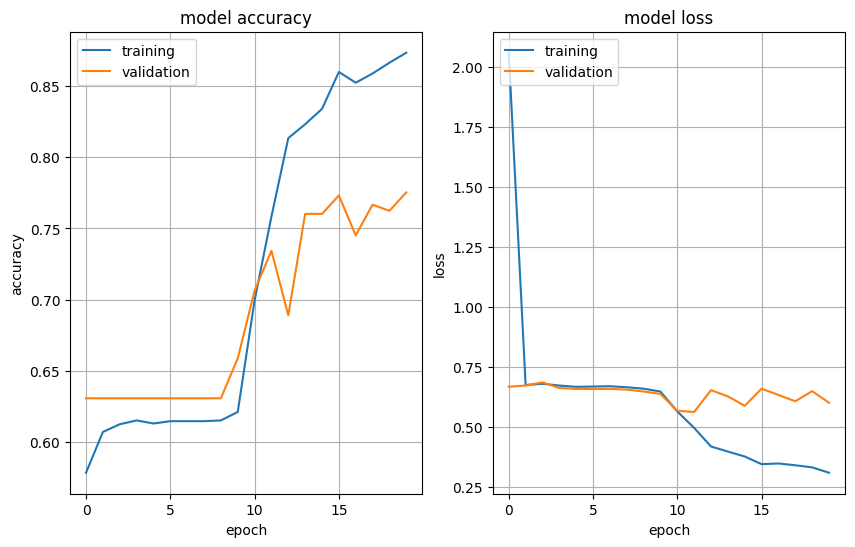

In [27]:
plot_model_metrics(history_model_2d)

# Testing the model



In [28]:
X, Y = pre_pro.create_dataset(verbose=False, is_training=False, start_index=0, end_index=10)

Processing: 21_3-2-2024=7_19_54
Found file
Filtering...
Downsampling...
21_3-2-2024=7_19_54
Reading annotations...
Processing: 23_2-2-2024=20_39_19
Found file
Filtering...
Downsampling...
23_2-2-2024=20_39_19
Reading annotations...
Processing: 19_19_fermat_12
Found file
Filtering...
Downsampling...
19_19_fermat_12
Reading annotations...
Processing: 17_20240203_081105
Processing: 23_2-2-2024=20_42_49
Found file
Filtering...
Downsampling...
23_2-2-2024=20_42_49
Reading annotations...
Processing: 20_r23_dariose
Found file
Filtering...
Downsampling...
20_r23_dariose
Reading annotations...
Processing: 3_2-2-2024=22_1_6
Found file
Filtering...
Downsampling...
3_2-2-2024=22_1_6
Reading annotations...
Processing: 24_2
Found file
Filtering...
Downsampling...
24_2
Reading annotations...
Processing: 18_3-2-2024=6_55_2
Found file
Filtering...
Downsampling...
18_3-2-2024=6_55_2
Reading annotations...
Processing: 9_2-2-2024=21_2_1
Found file
Filtering...
Downsampling...
9_2-2-2024=21_2_1
Reading ann

In [29]:
X_test_augmented = []
y_test_augmented = []

# Iterate over all the data
for i, signal in enumerate(X):
    signals = augment.random_augment(signal)
    X_test_augmented.append(signals)
    y_test_augmented.append(Y[i])

X_test_augmented = np.asarray(X_test_augmented)
y_test_augmented = np.asarray(y_test_augmented)

In [30]:
X_test_augmented.shape, y_test_augmented.shape

((142, 3, 66000), (142,))

In [31]:
X_test_2d = get_all_spectograms(X_test_augmented)

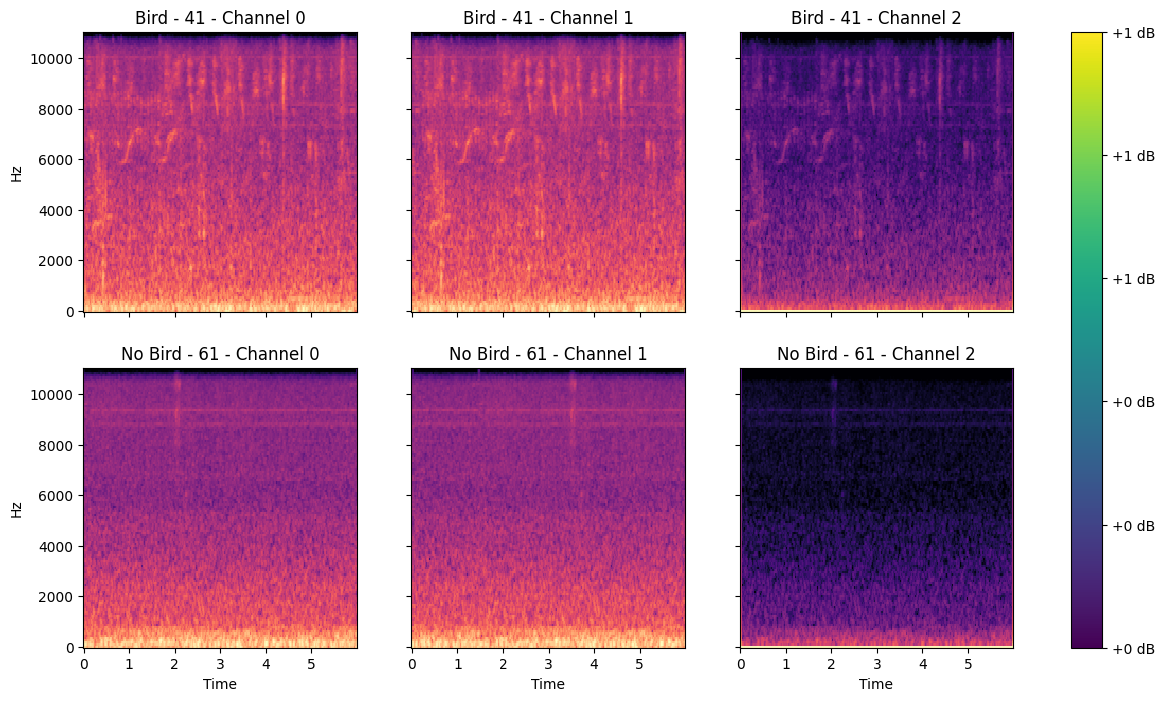

In [41]:
visualise_random_spectograms(X_test_2d, y_test_augmented, y_axis="linear")

In [33]:
y_preds = model_2d.predict(X_test_2d)
y_preds = np.argmax(y_preds, axis=1)

5/5 [==============================] - 1s 66ms/step


In [34]:
y_true = np.argmax(to_categorical(y_test_augmented), axis=1)

In [35]:
cr = classification_report(y_true, y_preds, target_names=['NO BIRD', 'BIRD'])
print(cr)

              precision    recall  f1-score   support

     NO BIRD       0.59      1.00      0.74        32
        BIRD       1.00      0.80      0.89       110

    accuracy                           0.85       142
   macro avg       0.80      0.90      0.82       142
weighted avg       0.91      0.85      0.86       142



In [36]:
def plot_confusion_matrix(y_true, y_pred, classes, title, cmap="jet", precision=2):

    y_true=y_true.astype(int)
    y_pred=y_pred.astype(int)

    np.set_printoptions(precision=precision)


    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(6, 6))
    ax.grid(False)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    # ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=classes,
        yticklabels=classes,
        ylabel='True label',
        xlabel='Predicted label'
    )

    # Rotate the tick labels and set their alignment.
    plt.setp(
        ax.get_xticklabels(),
        rotation=45,
        ha="right",
        rotation_mode="anchor"
    )

    # Loop over data dimensions and create text annotations.
    fmt = '.' + str(precision) + 'f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "coral"
            )
    fig.tight_layout()

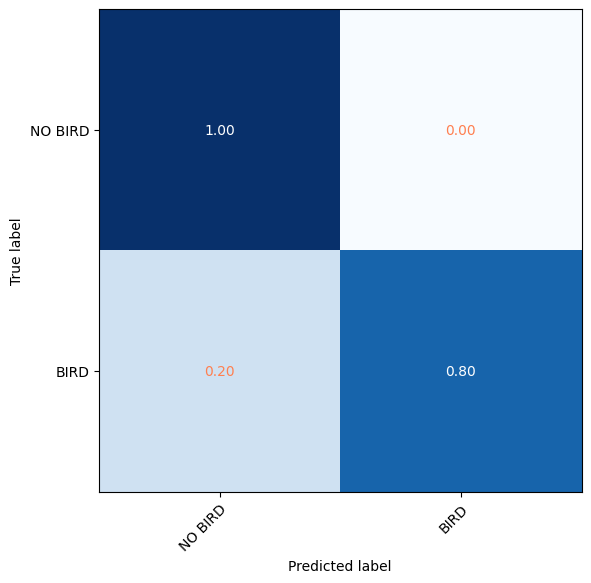

In [37]:
plot_confusion_matrix(y_true, y_preds, ['NO BIRD', 'BIRD'], title="Confusion matrix", cmap="Blues", precision=2)